# Czyszczenie danych

<div class="alert alert-block alert-success">
<b>Definicja</b> 

<b>Czyszczenie danych</b> jest to proces polegający na identyfikacji i naprawie różnego rodzaju błędów w danych. 
</div>

<div class="alert alert-block alert-info">
<b>Info</b> 

Czyszczenie danych obejmuje zazwyczaj następujące elementy:
- czyszczenie formatów danych
- czyszczenie kodowania zmiennych kategorycznych
- czyszczenie nieprawidłowych wartości zmiennych numerycznych
- czyszczenie wartości odstających
- usuwanie duplikatów
- imputacja wartości brakujących
</div>

<div class="alert alert-block alert-danger">
<b>Uwaga!</b> 
    
<b>Czyszczenie danych</b> stanowi jeden z ważniejszych etapów w procesie budowy modeli uczenia maszynowego, dlatego należy mu poświęcić dużo uwagi. Zazwyczaj stanowi też jedną z najbardziej czasochłonnych faz i może wymagać czasem wielu iteracji polegających na identyfikacji i naprawie kolejnych nieprawidłowości a następnie analizy impaktu zmian na wyniki modelu. 
Należy również pamiętać, że czyszczenie danych musi być poprzedzone ich dobrym zrozumieniem, inaczej nie będzie możliwe uzyskanie danych poprawnych pod kątem logiki biznesowej.
</div>

W tym notebooku przedstawione zostaną 2 przypadki - czyszczenie danych tabularycznych oraz czyszczenie szeregu czasowego. Najpierw jednak import bibliotek i wygenerowanie danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Wygenerowanie danych

Posłużymy się tutaj dwoma przykładami danych wymagających wyczyszczenia - danymi tabularycznymi reprezentującymi dane pacjentów oraz szeregiem czasowym pokazującym sprzedaż produktu o silnej sezonowości 

In [2]:
def generate_ts_data(month_coef=100, week_coef=10, day_coef=1, random_coef =10000):
    dates = pd.date_range(start="2016-01-01", end="2020-12-31", freq ="D")
    df = pd.DataFrame(dates, columns=["SalesDate"])
    df["Month"] = df.SalesDate.dt.month
    df["Week"] = df.SalesDate.dt.isocalendar().week
    df["Year"] = df.SalesDate.dt.year
    df["WeekDay"] = df.SalesDate.dt.dayofweek+1
    df["SLSU"] = ((np.power(6.5-df.Month,2))*month_coef + (np.power(26.5-df.Week,2))*week_coef +df.WeekDay*day_coef)*np.sqrt(df["Year"]-df["Year"].min()+1)
    df["SLSU"] = np.where((df["SalesDate"]>="2019-11-01")&(df["SalesDate"]<="2020-03-01"), 0, (df["SLSU"]))
    df["SLSU"] = df["SLSU"] + np.random.choice(a=[0,df["SLSU"].max()*0.2], size=len(df),p=[0.998, 0.002])
    return df.loc[:,["SalesDate","SLSU"]]

In [3]:
def generate_tabular_data(len_data=300):
    id = range(len_data)
    age = np.random.randint(low=5,high=100,size=len_data)
    weight = np.round(np.random.normal(loc=60,scale=10,size=len_data))
    height = np.round(np.random.normal(loc=160,scale=12,size=len_data))
    bmi = np.round(weight/(height/100)**2,1)
    city = np.random.choice(["Gdańsk","Gdynia", "Wejherowo", "Kościerzyna","Gdansk", "Koscierzyna"], p=[0.4, 0.2, 0.1, 0.1, 0.1, 0.1], size=len_data)
    num_covid_tests = np.random.randint(low=0,high=5,size=len_data)
    num_positive_tests = (num_covid_tests - num_covid_tests *np.random.choice(np.arange(6),p=[0.65, 0.2, 0.1, 0.02, 0.02, 0.01], size=len_data)).astype(int) + np.random.choice(a=[0,1], size=len_data,p=[0.9, 0.1])
    sex = np.random.choice(["M", "F", "N"], size=len_data, p=[0.45, 0.45, 0.1])
    dict_data = {"unique_id":id, "age":age, "weight":weight, "height":height, "bmi":bmi, "city":city,
                "num_covid_tests":num_covid_tests, "num_positive_tests":num_positive_tests, "sex":sex}
    df = pd.DataFrame(dict_data)
    df["num_covid_tests"] = np.where(df["num_covid_tests"]==0, np.nan, df["num_covid_tests"])
    df["weight"] = df["weight"].astype(str)
    df["height"] = df["height"] * np.random.choice([1,2], p =[0.99, 0.01], size=len_data)
    df["bmi"] = df["bmi"] * np.random.choice([1,np.random.rand()], p =[0.9, 0.1], size=len_data)
    df["age"] = np.where(df["age"]>65,np.nan, df["age"])
    df["city"] = np.select([df["bmi"]>30,df["bmi"]<=20, df["bmi"]<=30],[df["city"].str.lower(), df["city"].str.upper(), df["city"]])
    return pd.concat([df, df.sample(frac=0.05)])

# Czyszczenie danych tabularycznych

In [4]:
df = generate_tabular_data(len_data=300)

Pierwszym krokiem w czyszczeniu danych powinno zawsze być przyjrzenie się wycinkowi danych oraz podstawowym informacjom o naszej ramce danych:

In [5]:
df.head()

,unique_id,age,weight,height,bmi,city,num_covid_tests,num_positive_tests,sex
0,0,23.0,52.0,163.0,19.6,GDANSK,4.0,5,M
1,1,NaN,54.0,136.0,29.2,Gdynia,NaN,0,F
2,2,NaN,79.0,181.0,24.1,Koscierzyna,2.0,0,N
3,3,36.0,76.0,152.0,32.9,gdańsk,4.0,4,M
4,4,30.0,66.0,151.0,28.9,Gdansk,4.0,-8,F


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315 entries, 0 to 254
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           315 non-null    int64  
 1   age                 204 non-null    float64
 2   weight              315 non-null    object 
 3   height              315 non-null    float64
 4   bmi                 315 non-null    float64
 5   city                315 non-null    object 
 6   num_covid_tests     253 non-null    float64
 7   num_positive_tests  315 non-null    int32  
 8   sex                 315 non-null    object 
dtypes: float64(4), int32(1), int64(1), object(3)
memory usage: 23.4+ KB


## Formaty danych

najczęściej występującym problemem jest formatowanie zmiennych numerycznych jako kategorycznych, tutaj widzimy to np. dla zmiennej weight, może to wynikać również z nieprawidłowych wartości występujących w takich kolumnach.

In [7]:
df.select_dtypes("object")

,weight,city,sex
0,52.0,GDANSK,M
1,54.0,Gdynia,F
2,79.0,Koscierzyna,N
3,76.0,gdańsk,M
4,66.0,Gdansk,F
...,...,...,...
50,57.0,GDAŃSK,F
161,72.0,Gdansk,M
60,59.0,Gdansk,F
32,46.0,GDAŃSK,F


In [8]:
df.select_dtypes("float64")

,age,height,bmi,num_covid_tests
0,23.0,163.0,19.60000,4.0
1,NaN,136.0,29.20000,NaN
2,NaN,181.0,24.10000,2.0
3,36.0,152.0,32.90000,4.0
4,30.0,151.0,28.90000,4.0
...,...,...,...,...
50,64.0,170.0,19.70000,3.0
161,NaN,165.0,26.40000,NaN
60,47.0,166.0,21.40000,NaN
32,46.0,167.0,16.50000,3.0


Ponadto niektóre z powyższych zmiennych np. num_covid_tests wydają się bardziej pasować do formatu int niż float, jednak należy pamiętać, że zmienne zawierające brakujące wartości są automatycznie konwertowane na format float, dlatego na razie ograniczymy się do konwersji dla zmiennej weight.

In [9]:
columns_to_convert = ["weight"]
df[columns_to_convert] = df[columns_to_convert].astype("float64")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315 entries, 0 to 254
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           315 non-null    int64  
 1   age                 204 non-null    float64
 2   weight              315 non-null    float64
 3   height              315 non-null    float64
 4   bmi                 315 non-null    float64
 5   city                315 non-null    object 
 6   num_covid_tests     253 non-null    float64
 7   num_positive_tests  315 non-null    int32  
 8   sex                 315 non-null    object 
dtypes: float64(5), int32(1), int64(1), object(2)
memory usage: 23.4+ KB


## Atrybuty zmiennych kategorycznych

Zmienne kategoryczne są szczególnie narażone na błędy wynikające z literówek lub nieprawidłowego kodowania, co prowadzi do błędnego zwiększenia liczby ich unikalnych atrybutów. Można to zaobserwować dla przedstawionych poniżej zmiennych:

In [10]:
for column in df.select_dtypes("object").columns.tolist():
    print("*"*20)
    print(column.upper())
    print("*"*20)
    print(df[column].value_counts())

********************
CITY
********************
Gdańsk         72
Gdynia         42
GDAŃSK         36
Gdansk         22
gdańsk         21
Wejherowo      19
Kościerzyna    18
Koscierzyna    17
WEJHEROWO      10
GDYNIA         10
GDANSK         10
KOSCIERZYNA    10
KOŚCIERZYNA     7
wejherowo       6
gdynia          5
kościerzyna     4
gdansk          4
koscierzyna     2
Name: city, dtype: int64
********************
SEX
********************
F    143
M    135
N     37
Name: sex, dtype: int64


Jak widać zmienna city jest obarczona licznymi błędami wynikającymi z literówek oraz używania róznej wielkości liter. Tutaj błędy mogą stosunkowo łatwo zostać naprawione, jednak najczęściej do takiej poprawy niezbędna jest wiedza biznesowa odnośnie tego jakie atrybuty powinna dana zmienna posiadać i co one oznaczają.

In [11]:
df["city"] = df["city"].str.capitalize()
df["city"] = df["city"].replace({"Gdansk":"Gdańsk", "Koscierzyna":"Kościerzyna"})
df["city"].value_counts()

Gdańsk         165
Kościerzyna     58
Gdynia          57
Wejherowo       35
Name: city, dtype: int64

W przypadku zmiennej oznaczającej płeć pacjenta poza oczekiwanymi atrybutami M i F występuje jeszcze jedno oznaczenie - N. Przy założeniu, że nie ma żadnych wytycznych biznesowych określających, że taka wartość w tej kolumnie oznacza np. brak danych, musimy potraktować tą wartość jako błędną i oznaczyć jako brakującą. Tutaj zamienimy tę wartość na pustą a wypełnieniem jej zajmiemy się w kolejnych sekcjach.

In [12]:
df["sex"] = np.where(df["sex"]=="N",np.nan, df["sex"])
df["sex"].value_counts(dropna=False)

F      143
M      135
NaN     37
Name: sex, dtype: int64

## Weryfikacja duplikatów

Kolejnym istotnym krokiem jest weryfikacja czy w danych nie występują duplikaty. Aby zbadać występowanie duplikatów dla danych niezbędna jest wiedza jakie kolumny wyznaczają unikalne kombinacje. W tym wypadku zakładamy, że odpowiada za to kolumna unique_id, zatem wystarczy porównać liczbę jej unikalnych wartości z liczebnością ramki danych.

In [13]:
df["unique_id"].nunique(), df.shape[0]

(300, 315)

Jak widać w danych występują duplikaty, do ich usunięcia najprościej wykorzystać funkcję drop_duplicates, wybierając jako subset unique_id. Funkcja daje również możliwość wyboru, który rekord zachować przy wykryciu duplikatów, załóżmy, że tutaj interesuje nas ostatni rekord bo reprezentuje np. najnowszy wpis w danych.

In [14]:
df = df.drop_duplicates(subset=["unique_id"], keep='last')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 254
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           300 non-null    int64  
 1   age                 195 non-null    float64
 2   weight              300 non-null    float64
 3   height              300 non-null    float64
 4   bmi                 300 non-null    float64
 5   city                300 non-null    object 
 6   num_covid_tests     241 non-null    float64
 7   num_positive_tests  300 non-null    int32  
 8   sex                 263 non-null    object 
dtypes: float64(5), int32(1), int64(1), object(2)
memory usage: 22.3+ KB


## Sprawdzanie zmiennych numerycznych

Kolejnym krokiem jest czyszczenie zmiennych numerycznych, co obejmować będzie identyfikację i naprawianie wartości nieprawidłowych z punktu widzenia logiki biznesowej oraz wartości odstających.

In [15]:
df.describe()

,unique_id,age,weight,height,bmi,num_covid_tests,num_positive_tests
count,300.000000,195.000000,300.000000,300.000000,300.000000,241.000000,300.000000
mean,149.500000,33.635897,60.200000,159.726667,23.561514,2.435685,0.916667
std,86.746758,16.749080,9.841894,11.521622,5.353421,1.116641,2.444649
min,0.000000,5.000000,28.000000,126.000000,9.253101,1.000000,-12.000000
25%,74.750000,19.000000,54.000000,151.000000,19.864537,1.000000,0.000000
50%,149.500000,34.000000,60.000000,160.000000,23.000000,2.000000,1.000000
75%,224.250000,47.000000,66.000000,168.000000,26.875000,3.000000,3.000000
max,299.000000,65.000000,86.000000,187.000000,38.800000,4.000000,5.000000


analizując powyższe statystyki dla zmiennych numerycznych możemy łatwo zauważyć występowanie wartości nieprawidłowych w postaci ujemnych wartości dla zmiennej num_positive_tests, która z założenia powinna być nieujemna. Ponadto można tutaj łatwo zauważyć występowanie wartości odstających dla zmiennej height. Dokładny proces identyfikacji wartości odstających został bardziej szczegółowo omówiony w osobnym notebooku, zatem tutaj ograniczymy się do oznaczenia takich wartosci jako brakujące, przyjmując arbitralnie wielkość progu.

In [16]:
df["height"] = np.where(df["height"]>=230,np.nan, df["height"])
df["num_positive_tests"] = np.where(df["num_positive_tests"]<0,np.nan, df["num_positive_tests"])
df.describe()

,unique_id,age,weight,height,bmi,num_covid_tests,num_positive_tests
count,300.000000,195.000000,300.000000,300.000000,300.000000,241.000000,265.000000
mean,149.500000,33.635897,60.200000,159.726667,23.561514,2.435685,1.532075
std,86.746758,16.749080,9.841894,11.521622,5.353421,1.116641,1.487291
min,0.000000,5.000000,28.000000,126.000000,9.253101,1.000000,0.000000
25%,74.750000,19.000000,54.000000,151.000000,19.864537,1.000000,0.000000
50%,149.500000,34.000000,60.000000,160.000000,23.000000,2.000000,1.000000
75%,224.250000,47.000000,66.000000,168.000000,26.875000,3.000000,3.000000
max,299.000000,65.000000,86.000000,187.000000,38.800000,4.000000,5.000000


## Relacje pomiędzy zmiennymi

Oprócz analizy pojedynczych zmiennych czyszczenie danych powinno obejmować również analizę relacji logicznych pomiędzy poszczególnymi zmiennymi, wynikające z logiki biznesowej. Takie relacje mogą obejmować zarówno zestawienie wartości pojedynczych zmiennych jak i weryfikacje zmiennych wyliczanych na ich podstwie.

Przykładem takiej relacji w poniższych danych są zmienne num_covid_tests i num_positive_tests, za nieprawidłowe należy uznać wszystkie rekordy, dla których ta pierwsza zmienna jest mniejsza od drugiej

In [17]:
df[df["num_covid_tests"]<df["num_positive_tests"]]

,unique_id,age,weight,height,bmi,city,num_covid_tests,num_positive_tests,sex
0,0,23.0,52.0,163.0,19.600000,Gdańsk,4.0,5.0,M
24,24,NaN,53.0,143.0,25.900000,Kościerzyna,2.0,3.0,F
27,27,53.0,67.0,161.0,25.800000,Gdańsk,4.0,5.0,NaN
34,34,NaN,53.0,166.0,15.584169,Gdańsk,2.0,3.0,F
51,51,32.0,50.0,141.0,25.100000,Gdynia,3.0,4.0,NaN
58,58,26.0,78.0,164.0,29.000000,Gdynia,1.0,2.0,M
76,76,37.0,56.0,149.0,25.200000,Kościerzyna,1.0,2.0,M
108,108,65.0,64.0,175.0,20.900000,Gdańsk,3.0,4.0,NaN
142,142,17.0,61.0,139.0,31.600000,Wejherowo,2.0,3.0,M
148,148,NaN,77.0,164.0,28.600000,Wejherowo,2.0,3.0,M


Przy założeniu, że wiemy iż bardziej wiarygodne są zapisy wartości zmiennej num_covid_tests można dokonać poprawy jak poniżej, alternatywą byłoby przypisanie takim przypadkom wartości pustej dla zmiennej num_positive_tests, ewentualnie usunięcie takich rekordów.

In [18]:
df["num_positive_tests"] = np.where(df["num_positive_tests"]>df["num_covid_tests"], df["num_covid_tests"], df["num_positive_tests"])
df[df["num_covid_tests"]<df["num_positive_tests"]]

,unique_id,age,weight,height,bmi,city,num_covid_tests,num_positive_tests,sex


zmienną wyliczoną na podstawie innych zmiennych reprezentuje tutaj bmi, znając formułę można zweryfikować czy wszędzie jest ona wyliczona prawidłowo:

In [19]:
df.loc[np.round(df["bmi"])!=np.round(df["weight"]/(df["height"]/100)**2)]

,unique_id,age,weight,height,bmi,city,num_covid_tests,num_positive_tests,sex
7,7,38.0,65.0,150.0,23.457422,Gdańsk,2.0,2.0,F
15,15,55.0,67.0,179.0,16.964018,Wejherowo,1.0,1.0,M
29,29,9.0,60.0,145.0,28.500000,Gdańsk,3.0,3.0,F
34,34,NaN,53.0,166.0,15.584169,Gdańsk,2.0,2.0,F
35,35,NaN,60.0,145.0,28.500000,Wejherowo,3.0,3.0,M
48,48,39.0,41.0,146.0,15.584169,Gdańsk,3.0,3.0,F
55,55,21.0,65.0,151.0,28.500000,Gdańsk,1.0,1.0,M
71,71,10.0,58.0,154.0,19.886049,Gdańsk,4.0,4.0,M
82,82,11.0,54.0,149.0,19.723714,Kościerzyna,4.0,4.0,F
87,87,6.0,52.0,152.0,22.500000,Wejherowo,1.0,1.0,F


jak widać istnieją rekordy, dla których wartość nie zgadza się z formułą, wprowadzamy zatem poprawki:

In [20]:
df["bmi"] = df["weight"]/(df["height"]/100)**2

## Imputacja wartości brakujących

<div class="alert alert-block alert-info">
<b>Info</b> 

rodzaje wartości brakujących
- MCAR - Missing Completely At Random
- MAR - Missing At Random
- MNAR - Missing Not At Random
</div>

<div class="alert alert-block alert-success">
<b>Definicja</b> 

<b>MCAR</b> wartości brakujące powstały w sposób całkowicie losowy, co oznacza, że nie istnieje związek pomiędzy występowaniem wartości brakujących w danej a zmiennej a ich występowaniem w pozostałych zmiennych ani pomiędzy wartościami jakiejkolwiek zmiennej a wartościami brakującymi rozważanej zmiennej 
</div>


<div class="alert alert-block alert-success">
<b>Definicja</b> 

<b>MAR</b>
wartości brakujące występują losowo, ale można się dopatrzeć związków pomiędzy ich występowaniem a wartościami którejś z pozostałych zmiennych
</div>

<div class="alert alert-block alert-success">
<b>Definicja</b> 

<b>MNAR</b> wartości brakujące występują w sposób systematyczny, co ma związek np. ze sposobem zbierania danych, pozostałe zmienne nie mówią nic na podstawie czego można by dokonać imputacji tych wartości, natomiast prawdopodobieństwo wystąpienia braku danych jest wprost związane z wartościami omawianej zmiennej. 
</div>

na początek importujemy bibliotekę missingno, która posiada szereg przydatnych wizualizacji do zrozumienia natury wartości brakujących

In [21]:
import missingno

podstawowa wizualizacja daje intuicję na temat liczby wartości brakujących, a co więcej pokazuje też relacje pomiędzy ich występowanie w poszczególnych zmiennych

<AxesSubplot:>

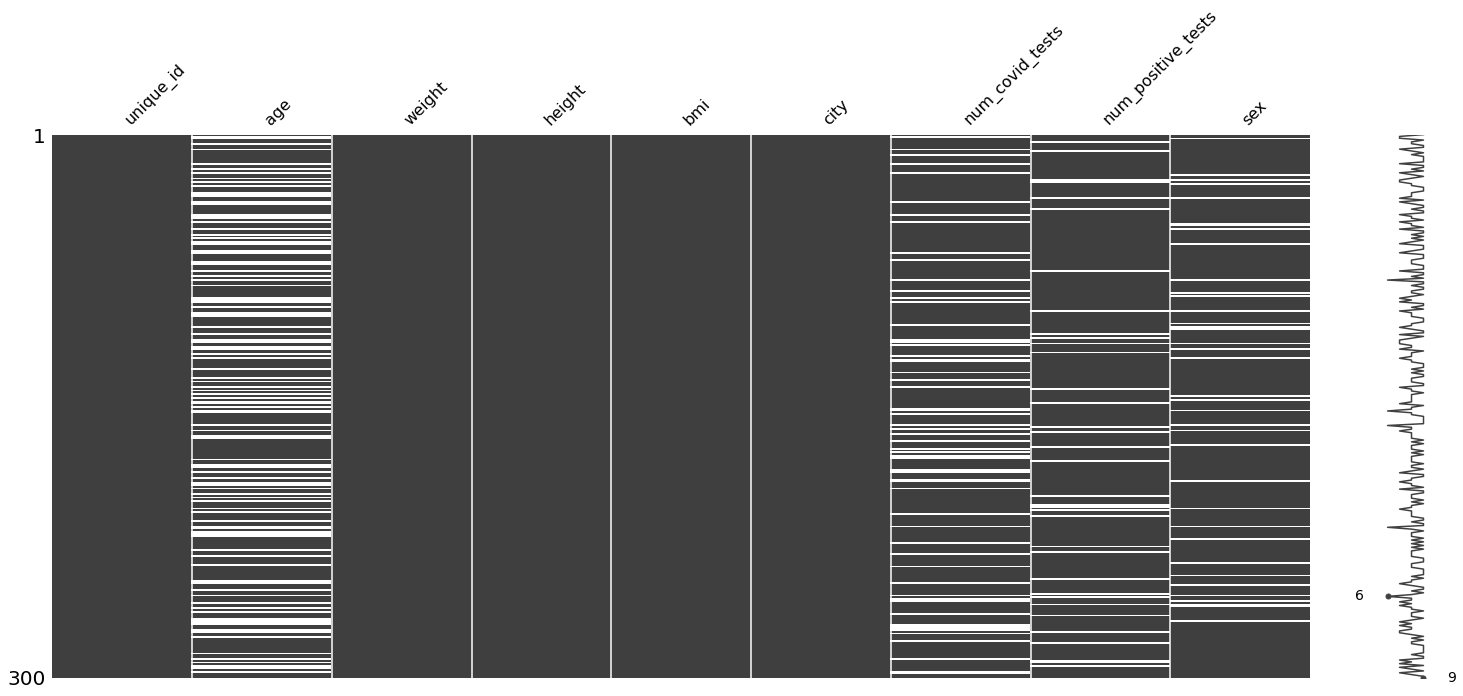

In [22]:
missingno.matrix(df)

tutaj można zauważyć relację między zmiennymi height i bmi, co jest oczywiście konsekwencją tego, że bmi jest liczone w oparciu o height. Ponadto widać też, że wartości brakujące zdecydowanie najczęściej występują dla zmiennej age.

Można również zaobserwować, że dla zmiennej age nie występują wartości wyższe niż 65 lat, zatem sposób potraktowania wartości brakujących zależy od istnienia informacji o maksymalnym wieku pacejentów w tym zbiorze danych - gdyby np okazało, że próba obejmuje również starsze osoby, ale przez jakiś błąd przy wprowadzaniu danych ich wiek się nie zapisał, należałoby potraktować taki przypadek jako MNAR i zastąpić wartością specjalną lub oznaczyć w osobnej kolumnie, w przeciwnym razie będzie to MCAR lub MAR.

Lepszemu wglądowi w to czy wartości brakujące dla danej zmiennej zależą od innych zmiennych może służyć również przedstawienie powyższej wizualizacji po posortowaniu wg wybranej zmiennej

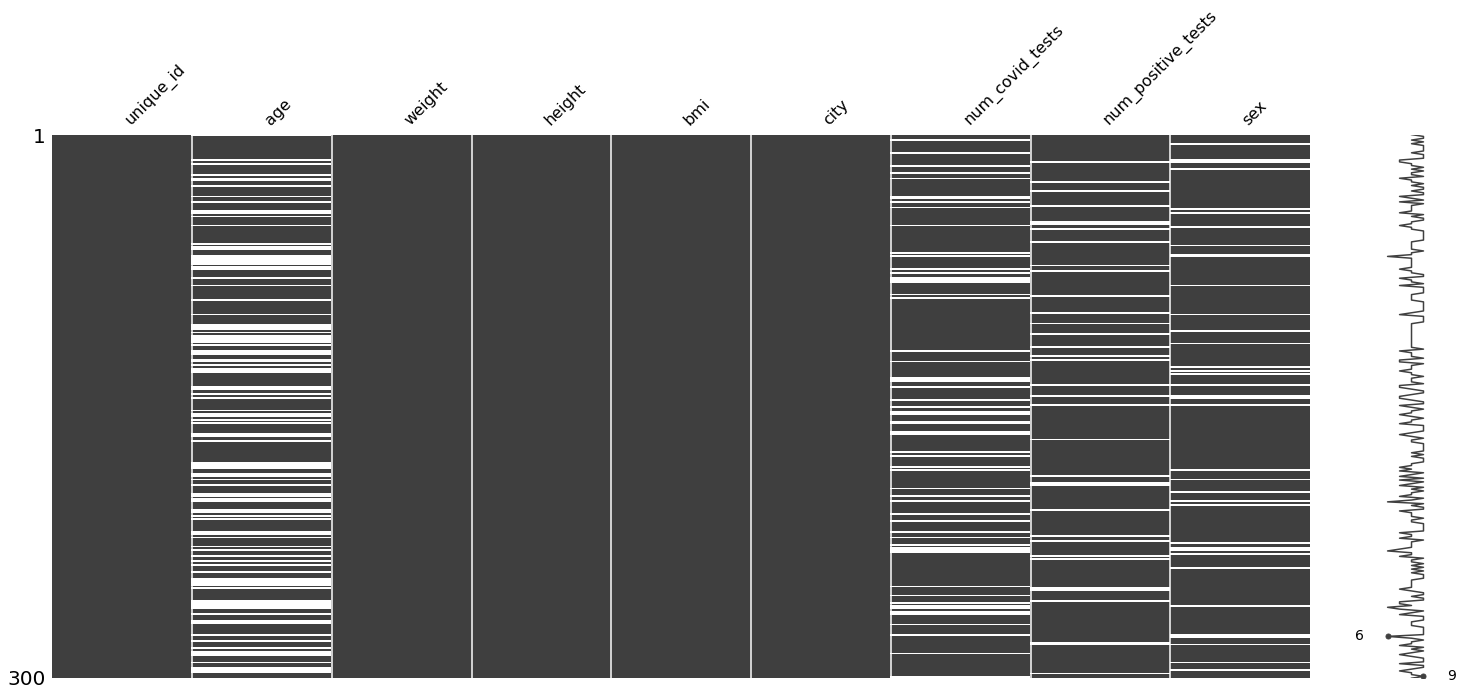

In [23]:
missingno.matrix(df.sort_values("weight"));

znalezieniu relacji może służyć również heatmap macierzy korelacji

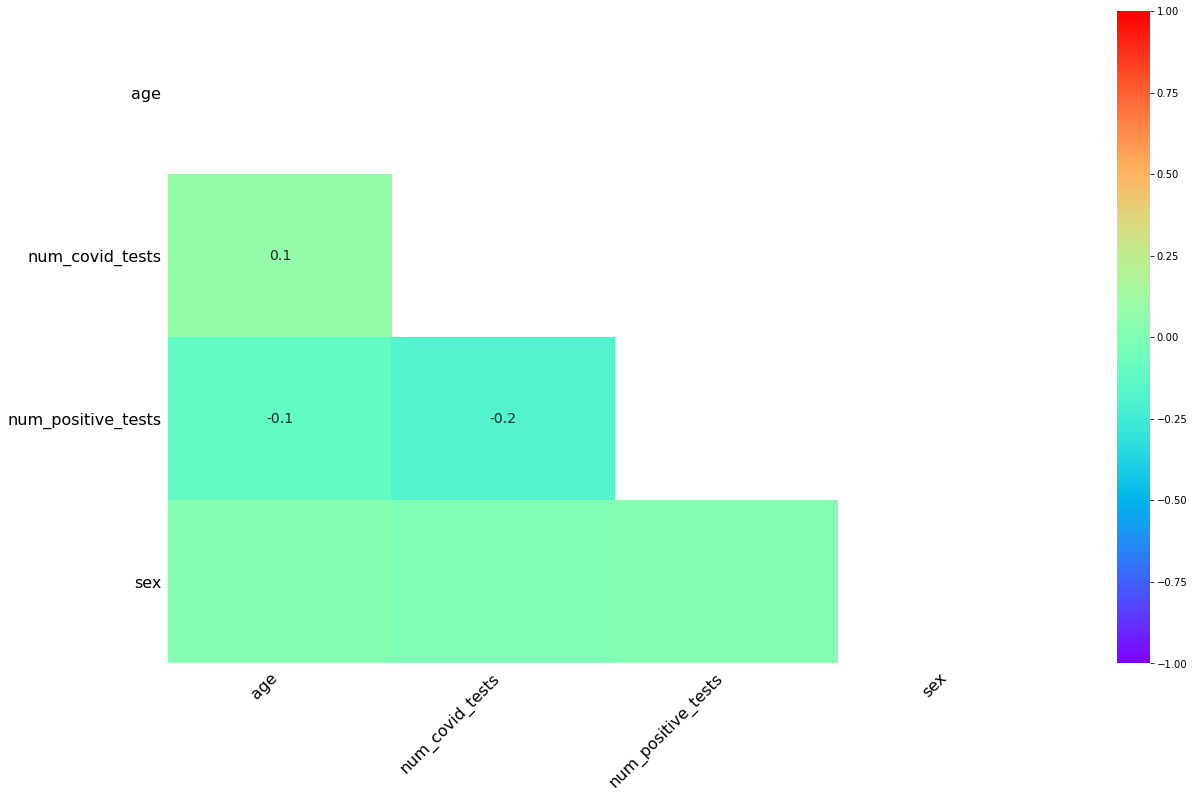

In [24]:
missingno.heatmap(df, cmap='rainbow');

Przyjmijmy, że faktycznie wystąpił systematyczny błąd przy zapisywaniu zmiennej age zatem reprezentuje ona MNAR, zmienna bmi w oczywisty sposób będzie MAR jako, że odwołuje się teraz wprost do innej zmiennej, pozostałe zmienne jeśli nie mamy jakiejś dodatkowej informacji co do natury powstania wartości brakujących należy uznać za MCAR

## Metody imputacji brakujących wartości

<div class="alert alert-block alert-danger">
<b>Uwaga!</b> 
    
Wszystkie przekształcenia wykorzystujące informacje o rozkładach cech należy implementować najpierw na zbiorze treningowym, a następnie w oparciu o rozkład ze zbioru treningowego - na zbiorze testowym. Inaczej wykorzystujemy informacje ze zbioru testowego i przestaje on być niezależny.
</div>

<div class="alert alert-block alert-info">
<b>imputacja wartością specjalną</b> 


- każdej brakującej obserwacji danej zmiennej przypisujemy np -1, -999 lub "N/A", świadomie stosując wartość niewystępującą w obserwacjach bez brakującej wartości
- przede wszystkim dla typu MNAR, gdzie zazwyczaj jest to jedyne prawidłowe podejście
- można zastosować tutaj również 0 jeśli w naturalny sposób oznacza ono brak danego zjawiska i logika biznesowa nakazuje tak interpretować wartość brakującą
</div>


<div class="alert alert-block alert-info">
<b>imputacja wartością stałą</b> 



- każdej brakującej obserwacji danej zmiennej przypisujemy tę samą wartość, w odróżnieniu od poprzedniej metody jest ona wyliczona w oparciu o dane treningowe
- imputacja średnią - zachowuje średnią z danych, ale zaniża wariancję, może być narażona na wpływ wartości odstających
- imputacja medianą - wolna od wpływu wartości odstających, ale wpływa na średnią i wariancję
- imputacja modą - najczęściej stosowana dla zmiennych kategorycznych, jeśli nie mają charakteru MNAR
</div>


<div class="alert alert-block alert-info">
<b>imputacja wg grup</b> 


- podobna do opisanej wyżej imputacji wartością stałą lecz realizowana osobno dla każdej zdefiniowanej w danych grupy
- to jak dobrać grupy może wynikać z wiedzy biznesowej lub z EDA
</div>

<div class="alert alert-block alert-info">
<b>Imputacja wartością losową</b> 


- w odróżnieniu od omówienych wcześniej metod, nie używamy tu tej samej wartości do wypełniania wszystkich obserwacji
- może polegać na losowaniu wartości spośród niepustych obserwacji danej zmiennej lub dopasowaniu do niej rozkładu statystycznego i losowaniu z rozkładu
</div>

<div class="alert alert-block alert-info">
<b>Imputacja na podstawie kolejności</b> 

- do stosowania w szeregach czasowych
- może obejmować zastąpienie brakujących obserwacji za pomocą poprzedniej wartości lub kolejnej wartości
- można stosować również metody oparte o większą liczbę poprzednich obserwacji np średnia krocząca
- dobrze może się sprawdzać również interpolacja
</div>

<div class="alert alert-block alert-info">
<b>imputacja wartością specjalną</b> 

Imputacja z wykorzystaniem modelu
- obejmuje przewidywanie brakujących wartości zmiennej na podstawie pozostałych zmiennych lub ich podgrupy
- stosowane są tu zarówno algorytmy regresji jak i KNN lub modele drzewiaste

</div>

### Przykłady imputacji

#### iImputacja wartością specjalną
Zmienną age uznaliśmy za MNAR, co sugeruje, że nie można się posłużyć statystykami z próbki, tylko należy użyć wartości specjalnej. Jeśli wiemy, że wartości brakujące reprezentują starsze osoby wstawienie tutaj wartości np -1 może nie być najlepszym rozwiązaniem, ponieważ takie podejście może zaburzyć monotoniczność relacji tej zmiennej ze zmienną celu, zamiast tego można spróbować wartości większej niż maksimum z obecnych danych np 70

In [25]:
df["age"] = df["age"] .fillna(70)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 254
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           300 non-null    int64  
 1   age                 300 non-null    float64
 2   weight              300 non-null    float64
 3   height              300 non-null    float64
 4   bmi                 300 non-null    float64
 5   city                300 non-null    object 
 6   num_covid_tests     241 non-null    float64
 7   num_positive_tests  265 non-null    float64
 8   sex                 263 non-null    object 
dtypes: float64(6), int64(1), object(2)
memory usage: 23.4+ KB


#### Imputacja wartością stałą
Pozostałe zmienne z brakującymi wartościami należy wypełnić w oparciu o wartości z danych treningowych, zanim do tego przystąpimy należy podzielić próbkę, co będzie reprezentowało rzeczywistą sytuację, gdy na podstawie dostępnych danych będziemy uzupełniać te przyszłe.

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size =0.25, random_state=42)

tutaj dla uproszczenia stosujemy tylko prosty podział na zbiór treningowy i testowy, generalnie najlepszą praktyką jest wydzielenie osobnego zbioru testowego reprezentującego zdolność modelu do generalizacji na nowych, niewidzianych wcześniej danych i dobór najlepszego zestawu parametrów i transformacji stosując crosswalidację na zbiorze treningowym.

##### Imputacja zmiennych kategorycznych
w przypadku zmiennych kategorycznych, gdy nie stosujemy imputacji wartością specjalną najczęściej spotykaną strategią jest wypełnianie najczęściej występującą wartością w danych treningowych

In [27]:
X_train_sex_mode = X_train["sex"].dropna().mode()[0]
X_train["sex"] = X_train["sex"].fillna(X_train_sex_mode)
X_test["sex"] = X_test["sex"].fillna(X_train_sex_mode)

C:\Users\KNAJMA~1\AppData\Local\Temp/ipykernel_16120/1313340584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["sex"] = X_train["sex"].fillna(X_train_sex_mode)
C:\Users\KNAJMA~1\AppData\Local\Temp/ipykernel_16120/1313340584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["sex"] = X_test["sex"].fillna(X_train_sex_mode)


alternatywnie można też skorzystać z klasy SimpleImputer z biblioteki sklearn. Użycie tego typu transformerów stanowi dobrą praktykę, ponieważ można je potem łączyć w pipeline co ułatwia development i zmniejsza ryzyko popełnienia błędów takich jak np data leakage. Poniżej zaprezentujemy ponowny podział na zbiór treningowy i testowy oraz wypełnienie tej samej zmiennej z użyciem klasy SimpleImputer.

In [28]:
from sklearn.impute import SimpleImputer
X_train, X_test = train_test_split(df, test_size =0.25, random_state=42)
si_mode = SimpleImputer(strategy="most_frequent")
si_mode.fit(X_train["sex"].values.reshape(-1, 1))
X_train["sex"] = si_mode.transform(X_train["sex"].values.reshape(-1, 1))
X_test["sex"] = si_mode.transform(X_test["sex"].values.reshape(-1, 1))
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 297 to 106
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           225 non-null    int64  
 1   age                 225 non-null    float64
 2   weight              225 non-null    float64
 3   height              225 non-null    float64
 4   bmi                 225 non-null    float64
 5   city                225 non-null    object 
 6   num_covid_tests     180 non-null    float64
 7   num_positive_tests  198 non-null    float64
 8   sex                 225 non-null    object 
dtypes: float64(6), int64(1), object(2)
memory usage: 17.6+ KB


C:\Users\KNAJMA~1\AppData\Local\Temp/ipykernel_16120/2045433211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["sex"] = si_mode.transform(X_train["sex"].values.reshape(-1, 1))
C:\Users\KNAJMA~1\AppData\Local\Temp/ipykernel_16120/2045433211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["sex"] = si_mode.transform(X_test["sex"].values.reshape(-1, 1))


powyżej stosujemy SimpleImputer na tylko jednej kolumnie, inaczej wszystkie zmienne z brakującymi wartościami zostałyby wypełnione swoją najczęstszą wartością. Standardową praktyką jest użycie klasy ColumnTransformer do przypisywania odpowiednich transformacji poszczególnym grupom zmiennych, co zostanie zaprezentowane później.

##### Imputacja zmiennych numerycznych
załóżmy, że chcemy zainputować zmienne numeryczne korzystając z mediany, użycie mediany może być dobrą alternatywą dla używania średniej jeśli obawiamy się wpływu wartości odstających na średnią

In [29]:
si_median = SimpleImputer(strategy="median")
X_train_num = X_train.select_dtypes(exclude="object")
X_test_num = X_test.select_dtypes(exclude="object")
si_median.fit(X_train_num)
X_train_num = pd.DataFrame(si_median.transform(X_train_num), columns =X_train_num.columns)
X_test_num = pd.DataFrame(si_median.transform(X_test_num), columns =X_test_num.columns)
X_train = pd.concat([X_train_num, X_train.select_dtypes(include="object")],axis=1)
X_test = pd.concat([X_test_num, X_test.select_dtypes(include="object")],axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281 entries, 0 to 299
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           225 non-null    float64
 1   age                 225 non-null    float64
 2   weight              225 non-null    float64
 3   height              225 non-null    float64
 4   bmi                 225 non-null    float64
 5   num_covid_tests     225 non-null    float64
 6   num_positive_tests  225 non-null    float64
 7   city                225 non-null    object 
 8   sex                 225 non-null    object 
dtypes: float64(7), object(2)
memory usage: 22.0+ KB


#### Łączenie różnych metod imputacji z wykorzystaniem pipeline
jak już wspomniano najlepszą praktykę przy stosowaniu imputacji stanowi łączenie poszczególnych transformacji w Pipeline będący ciągiem transformacji, który może też na końcu zawierać model predykcyjny. Tutaj pokażemy pipeline łączący wszystkie wcześniej stosowane operacje imputacji danych.

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# przywrócenie danych do postaci sprzed imputacji
df["age"] = np.where(df["age"]>65, np.nan, df["age"])
X_train, X_test = train_test_split(df, test_size =0.25, random_state=42)

columns_to_impute_special_value =["age"]
columns_to_impute_mode = X_train.select_dtypes(include="object").columns.tolist()
columns_to_impute_median = list(set(X_train.select_dtypes(exclude="object").columns.tolist()) -set(columns_to_impute_special_value))

pipeline_sv = Pipeline(steps=[("special_value_imputer", SimpleImputer(strategy="constant", fill_value=70))])
pipeline_mode = Pipeline(steps=[("mode_imputer",SimpleImputer(strategy="most_frequent"))])
pipeline_num = Pipeline(steps=[("median_imputer",SimpleImputer(strategy="median"))])

column_transformer = ColumnTransformer(
                        transformers=[
                         ('special_value_imputation', pipeline_sv, columns_to_impute_special_value),
                         ('mode_imputation', pipeline_mode, columns_to_impute_mode),
                         ('median_imputation', pipeline_num, columns_to_impute_median)
                         ])
imputation_pipeline = Pipeline(steps=[("imputation", column_transformer)])

imputation_pipeline.fit(X_train)
X_train = pd.DataFrame(imputation_pipeline.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputation_pipeline.transform(X_test), columns=X_test.columns)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   unique_id           75 non-null     object
 1   age                 75 non-null     object
 2   weight              75 non-null     object
 3   height              75 non-null     object
 4   bmi                 75 non-null     object
 5   city                75 non-null     object
 6   num_covid_tests     75 non-null     object
 7   num_positive_tests  75 non-null     object
 8   sex                 75 non-null     object
dtypes: object(9)
memory usage: 5.4+ KB


#### Imputacja wg grupy
Wróćmy na chwilę do zmiennej age, załóżmy że jej braki danych nie są jednak wynikiem systematycznego błędu lecz występują losowo, a co więcej wiemy, że każde z miast ze zmiennej city charakteryzuje się specyficznym rozkładem dla zmiennej age. Wówczas imputacja mogłaby tutaj wyglądać następująco

In [31]:
X_train, X_test = train_test_split(df, test_size =0.25, random_state=42)
mean_age_by_city =X_train.groupby("city")["age"].mean().reset_index()
X_train = X_train.merge(mean_age_by_city, on ="city",suffixes=("","_mean"))
X_test = X_test.merge(mean_age_by_city, on ="city",suffixes=("","_mean"))
X_train["age"] = X_train["age"].fillna(X_train["age_mean"])
X_test["age"] = X_test["age"].fillna(X_test["age_mean"])
X_train.drop("age_mean", axis=1, inplace=True)
X_test.drop("age_mean", axis=1, inplace=True)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 74
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           75 non-null     int64  
 1   age                 75 non-null     float64
 2   weight              75 non-null     float64
 3   height              75 non-null     float64
 4   bmi                 75 non-null     float64
 5   city                75 non-null     object 
 6   num_covid_tests     61 non-null     float64
 7   num_positive_tests  67 non-null     float64
 8   sex                 68 non-null     object 
dtypes: float64(6), int64(1), object(2)
memory usage: 5.9+ KB


#### Imputacja z wykorzystaniem modelu
poniżej pokażemy jeszcze jak można do imputacji wykorzystać model ML na przykładzie klasy KNNImputer, która wykonuje imputację na podstawie wartości najbliższych obserwacji

In [32]:
from sklearn.impute import KNNImputer
X_train, X_test = train_test_split(df, test_size =0.25, random_state=42)
X_train_num = X_train.select_dtypes(exclude="object")
X_test_num = X_test.select_dtypes(exclude="object")
knn = KNNImputer(n_neighbors=5)
knn.fit(X_train_num)
X_train_num = pd.DataFrame(knn.transform(X_train_num), columns= X_train_num.columns)
X_test_num = pd.DataFrame(knn.transform(X_test_num), columns= X_test_num.columns)
X_train = pd.concat([X_train_num, X_train.select_dtypes(include="object")],axis=1)
X_test = pd.concat([X_test_num, X_test.select_dtypes(include="object")],axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281 entries, 0 to 299
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           225 non-null    float64
 1   age                 225 non-null    float64
 2   weight              225 non-null    float64
 3   height              225 non-null    float64
 4   bmi                 225 non-null    float64
 5   num_covid_tests     225 non-null    float64
 6   num_positive_tests  225 non-null    float64
 7   city                225 non-null    object 
 8   sex                 195 non-null    object 
dtypes: float64(7), object(2)
memory usage: 22.0+ KB


## Metody usuwania brakujących wartości

Drugim oprócz imputacji sposobem radzenia sobie z wartościami brakującymi jest ich usuwanie. Wybór pomiędzy usuwaniem a imputacją zależy w dużym stopniu od ilości dostępnych danych oraz poziomu koncentracji wartości brakujących, a także tego jak istotne są dla nas dane zmienne lub obserwacje.

<div class="alert alert-block alert-danger">
<b>Uwaga!</b> 
 
Należy pamiętać, żeby w przypadku stosowania usuwania brakujących obserwacji zacząć od usunięcia wszystkich niepotrzebnych kolumn, ponieważ mogą one potem niepotrzebnie wpłynąć na usuwanie obserwacji.
</div>

najwygodniejszą opcją usuwania w bibliotece pandas jest funkcja dropna, kilka przykładów poniżej

In [33]:
# usuwanie wszystkich obserwacji z jakimikolwiek wartościami brakującymi
df_nonull = df.dropna(axis=0, how="any")
df_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 0 to 254
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           117 non-null    int64  
 1   age                 117 non-null    float64
 2   weight              117 non-null    float64
 3   height              117 non-null    float64
 4   bmi                 117 non-null    float64
 5   city                117 non-null    object 
 6   num_covid_tests     117 non-null    float64
 7   num_positive_tests  117 non-null    float64
 8   sex                 117 non-null    object 
dtypes: float64(6), int64(1), object(2)
memory usage: 9.1+ KB


In [34]:
# usuwanie wszystkich obserwacji z progiem co najmniej 2 wartości brakujących
df_nonull = df.dropna(axis=0, thresh=df.shape[1]-2)
df_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295 entries, 0 to 254
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           295 non-null    int64  
 1   age                 195 non-null    float64
 2   weight              295 non-null    float64
 3   height              295 non-null    float64
 4   bmi                 295 non-null    float64
 5   city                295 non-null    object 
 6   num_covid_tests     241 non-null    float64
 7   num_positive_tests  260 non-null    float64
 8   sex                 263 non-null    object 
dtypes: float64(6), int64(1), object(2)
memory usage: 23.0+ KB


In [35]:
# usuwanie wszystkich obserwacji z progiem co najmniej 1 wartością brakującą dla kolumn age, num_covid_tests i num_positive_tests
df_nonull = df.dropna(axis=0, thresh=2, subset=["age", "num_covid_tests", "num_positive_tests"])
df_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 0 to 254
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unique_id           268 non-null    int64  
 1   age                 195 non-null    float64
 2   weight              268 non-null    float64
 3   height              268 non-null    float64
 4   bmi                 268 non-null    float64
 5   city                268 non-null    object 
 6   num_covid_tests     234 non-null    float64
 7   num_positive_tests  240 non-null    float64
 8   sex                 236 non-null    object 
dtypes: float64(6), int64(1), object(2)
memory usage: 20.9+ KB


In [36]:
# usuwanie kolumn mających co najmniej 10% wartości brakujących
df_nonull = df.dropna(axis=1, thresh=0.9*df.shape[0])
df_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 254
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   unique_id  300 non-null    int64  
 1   weight     300 non-null    float64
 2   height     300 non-null    float64
 3   bmi        300 non-null    float64
 4   city       300 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory usage: 14.1+ KB


# Czyszczenie szeregów czasowych

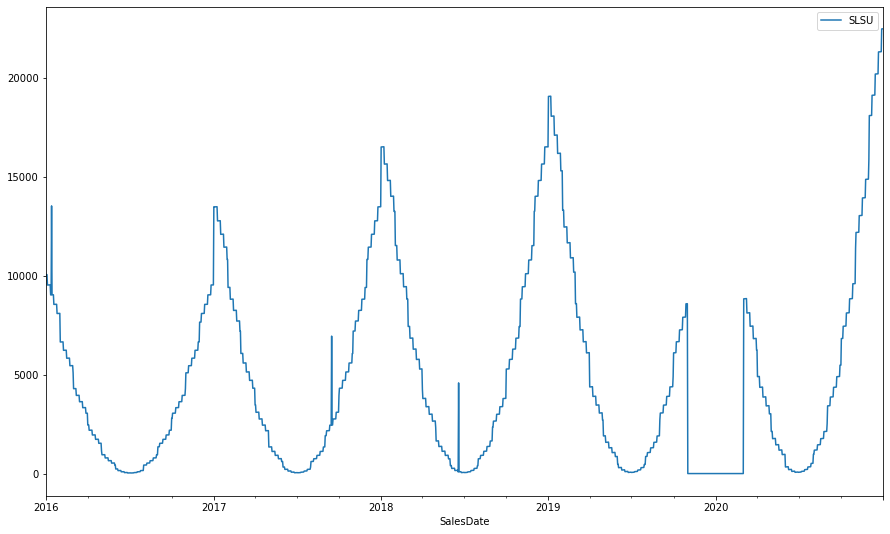

In [37]:
df_ts = generate_ts_data()
df_ts.set_index("SalesDate").plot(figsize=(15,9));

W czyszczeniu danych o charakterze szeregu czasowego bardzo użyteczna jest wizualna analiza danych. Analizując powyższy wykres można dostrzec dość regularny szereg czasowy z rocznym okresem sezonowości i trendem rosnącym. Widać również zaburzenia w postaci nieregularnie rozlokowanych pików w pojedynczych dniach oraz silnie zaburzony okres na przełomie 2019 i 2020.

In [38]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   SalesDate  1827 non-null   datetime64[ns]
 1   SLSU       1827 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB


Przed przejściem do dalszej analizy należy jeszcze upewnić się, że dane mają prawidłowe formaty i są odpowiednio posortowane, inaczej łatwo o błędne wnioski.

In [39]:
df_ts["SLSU"] = df_ts["SLSU"].astype("float64")
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   SalesDate  1827 non-null   datetime64[ns]
 1   SLSU       1827 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB


In [40]:
df_ts = df_ts.sort_values("SalesDate")
df_ts = df_ts.set_index("SalesDate")

<AxesSubplot:xlabel='SalesDate'>

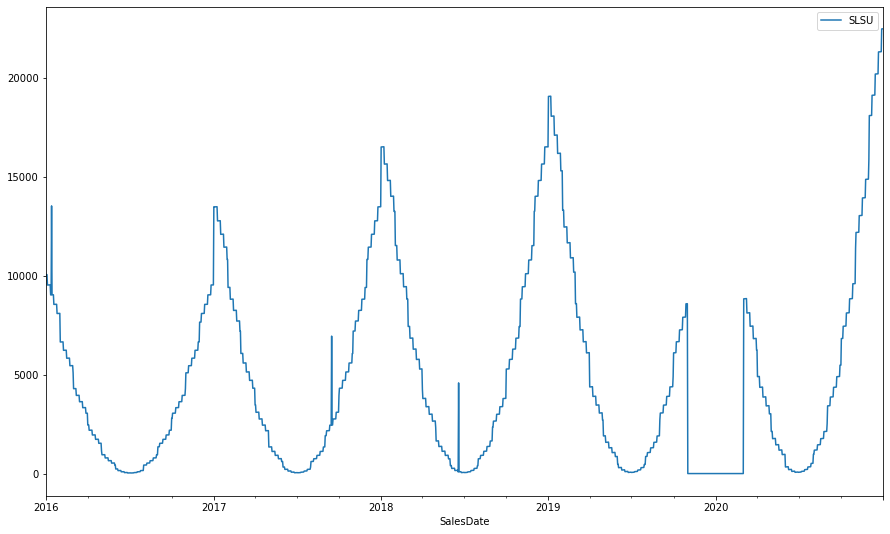

In [41]:
df_ts.plot(figsize=(15,9))

In [42]:
df_ts.index.nunique(), df_ts.shape[0]

(1827, 1827)

dane nie mają duplikatów, są posortowane a formaty są już poprawne, możemy się zatem skupić na oznaczaniu i imputacji wartości zaburzonych

<div class="alert alert-block alert-info">
<b>Info</b> 
    
Podstawą do oznaczenia danego zjawiska jako zaburzonego a następnie jego imputacji powinna być zawsze wiedza biznesowa odnośnie tego czy dane zjawisko ma charakter jednorazowy i już się nie powtórzy w analogicznym okresie
</div>

Istnieje wiele metod oznaczania anomalii w szeregach czasowych, mogą one też być mocno zależne od wiedzy na tematy powodu wystąpienia takiej anomali. Tutaj najpierw spróbujemy automatycznie wykryć pojedyńcze zaburzenia w oparciu o porównanie z medianą z sąsiednich obserwacji.

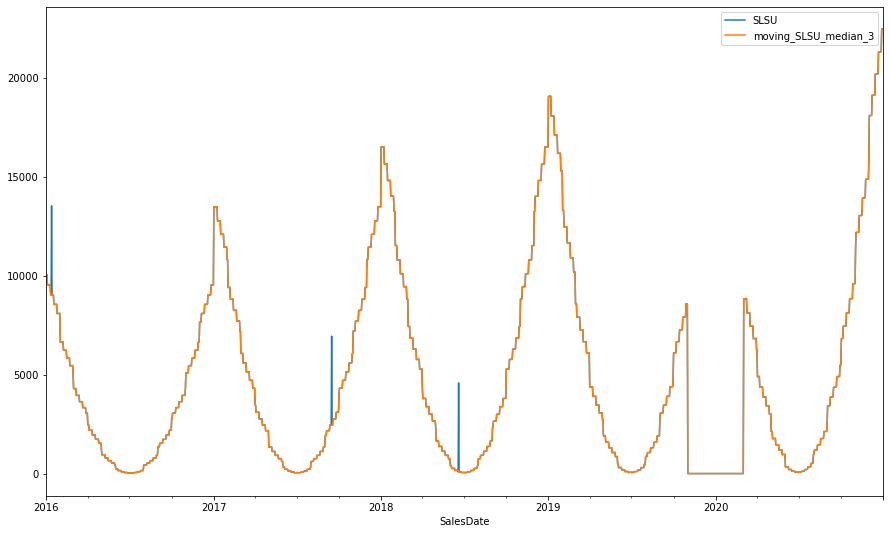

In [43]:
df_ts["moving_SLSU_median_3"] = df_ts["SLSU"].rolling(3, center=True, min_periods=1).median()
df_ts.plot(figsize=(15,9));

jak widać takie podejście dobrze oddziela naturalne obserwacje od pojedynczych zaburzeń, można za jego pomocą oznaczyć wartości odstające jeśli np zauważymy, że różnica pomiędzy wyliczoną medianą a wartością pierwotną wynosi ponad 15%

In [44]:
len(df_ts.loc[np.abs(df_ts["moving_SLSU_median_3"]-df_ts["SLSU"])>0.15*df_ts["SLSU"] ])

4

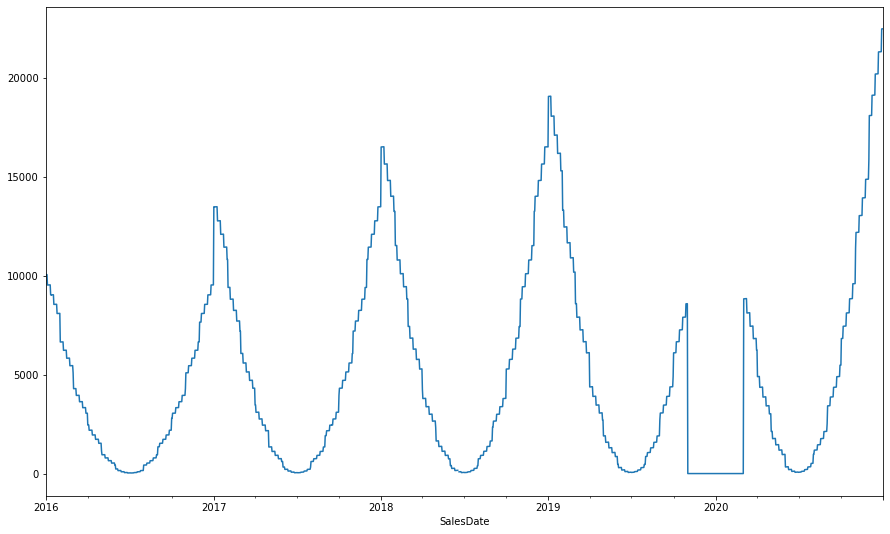

In [45]:
df_ts["SLSU"] =np.where(np.abs(df_ts["moving_SLSU_median_3"]-df_ts["SLSU"])>0.15*df_ts["SLSU"], np.nan, df_ts["SLSU"])
df_ts["SLSU"].plot(figsize=(15,9));

<div class="alert alert-block alert-danger">
<b>Uwaga!</b> 
    
Należy mieć świadomość, że przedstawiona powyżej metoda może również oznaczyć jako anomalia zupełnie naturalnie występujące obserwacje, wszystko zależy od konkretnej potrzeby przy czyszczeniu szeregu czasowego.
</div>

obserwacje oznaczone jako puste można następnie zaimputować za pomocą wyliczonej wcześniej mediany lub dokonać interpolacji liniowej

<AxesSubplot:xlabel='SalesDate'>

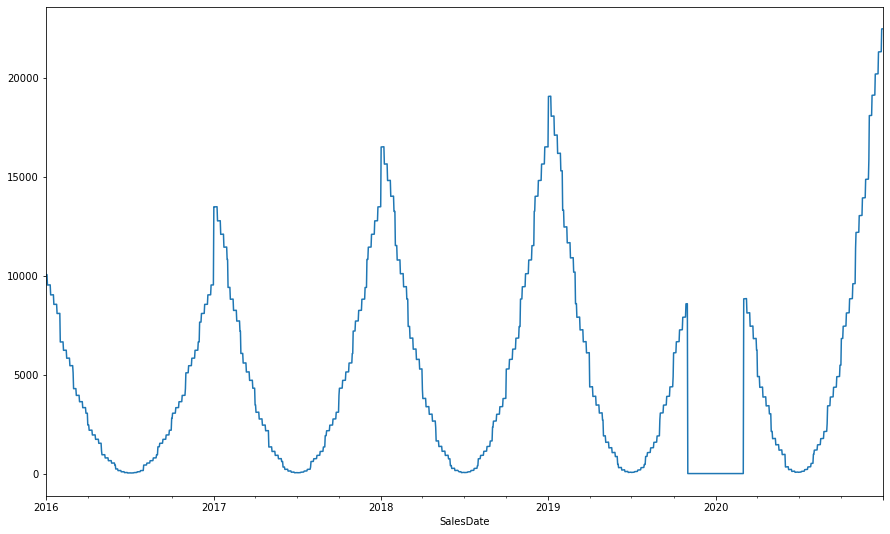

In [46]:
df_ts["SLSU"] = df_ts["SLSU"].interpolate(method="linear")
df_ts["SLSU"].plot(figsize=(15,9))

jak widać z poniższego wykresu, interpolacja liniowa nie będzie jednak użyteczna w celu wypełnienia dłuższych zaburzeń, w szczególności w przypadku gdy przypadają one w okresie sezonowego szczytu. Zamiast tego spróbujmy dokonać prognozy modelem szeregu czasowego w oparciu o wcześniejsze, niezaburzone dane.

<AxesSubplot:xlabel='SalesDate'>

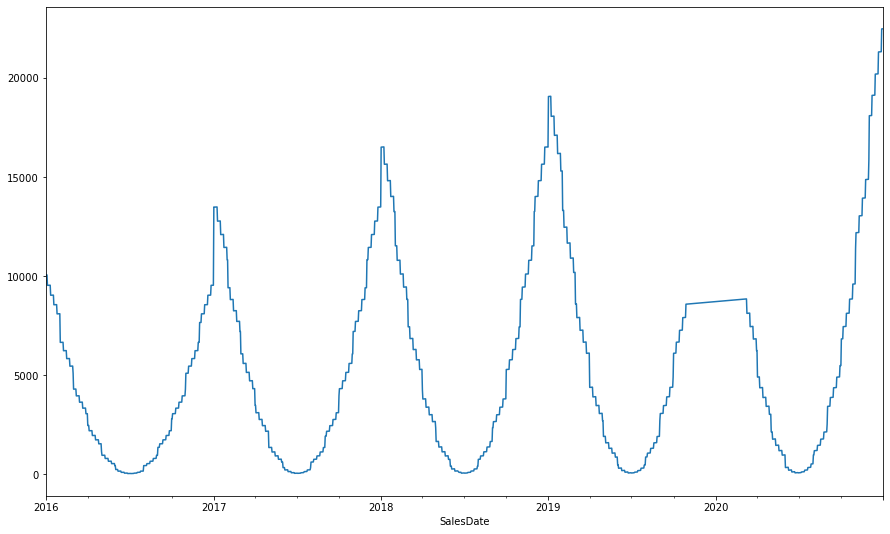

In [47]:
df_ts["SLSU"] = np.where(df_ts["SLSU"]==0, np.nan, df_ts["SLSU"])
df_ts["SLSU"].interpolate(method="linear").plot(figsize=(15,9))

In [48]:
df_ts["SLSU"]  = df_ts["SLSU"].fillna(0)

automatycznym sposobem na oznaczenie wartości odstających przy założeniu, że nie można tutaj po prostu patrzeć na obserwacje z wartością 0 jest porównanie z wartością sprzed roku a jeszcze lepiej z wygładzoną wartością, więc wygodnie jest użyć wyliczonej już wcześniej mediany kroczącej sprzed roku.

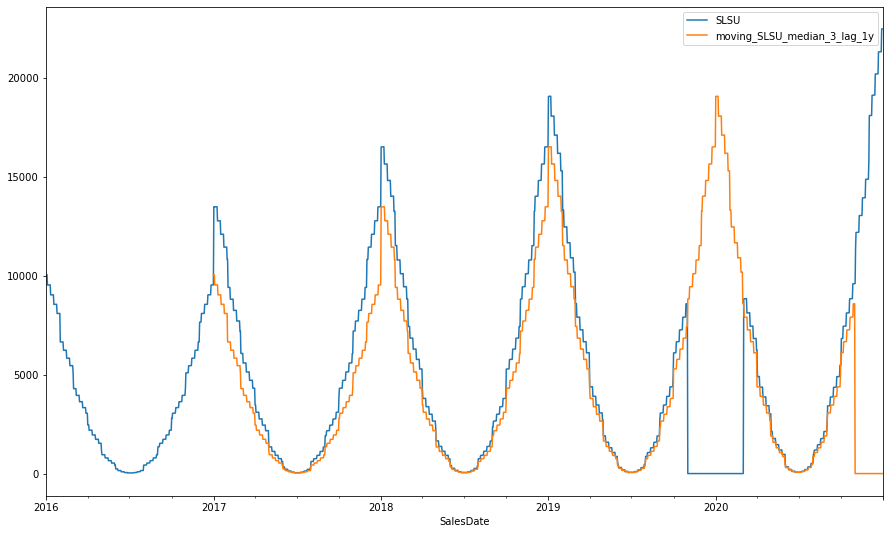

In [49]:
df_ts["moving_SLSU_median_3_lag_1y"] = df_ts["moving_SLSU_median_3"].shift(365)
df_ts[["SLSU", "moving_SLSU_median_3_lag_1y"]].plot(figsize=(15,9));

następnie można wyliczyć różnice pomiędzy wartością SLSU a medianą i oznaczyć jako puste wartości odstające wyznaczone np metodą IQR, przyjmując dodatkowo warunek, że interesują nas tylko wartości większe od IQR, aby nie wyzerować wartości rok po zaburzeniu

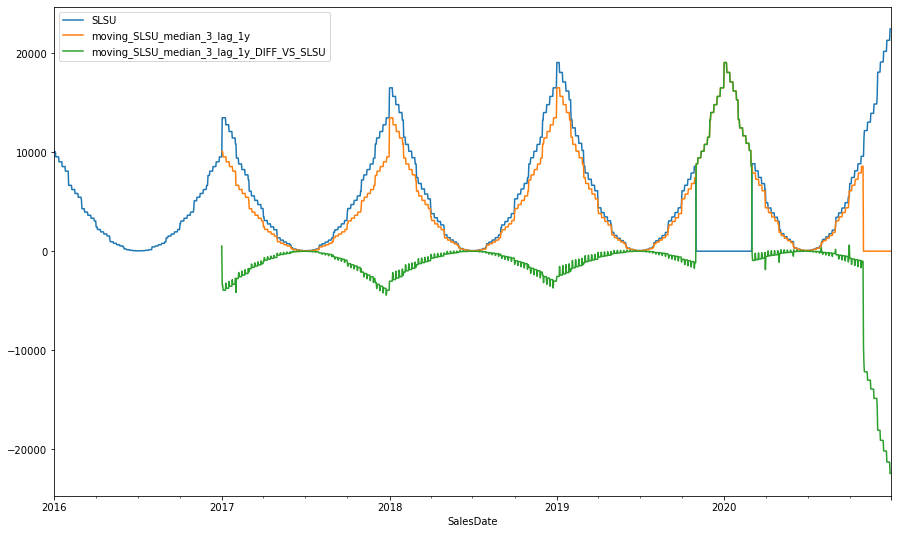

In [50]:
df_ts["moving_SLSU_median_3_lag_1y_DIFF_VS_SLSU"] =df_ts["moving_SLSU_median_3_lag_1y"] - df_ts["SLSU"] 
df_ts[["SLSU", "moving_SLSU_median_3_lag_1y", "moving_SLSU_median_3_lag_1y_DIFF_VS_SLSU"]].plot(figsize=(15,9));


In [51]:
df_ts["IQR"] = (df_ts["moving_SLSU_median_3_lag_1y_DIFF_VS_SLSU"].quantile(0.75) - df_ts["moving_SLSU_median_3_lag_1y_DIFF_VS_SLSU"].quantile(0.25))*1.5
df_ts.loc[df_ts["moving_SLSU_median_3_lag_1y_DIFF_VS_SLSU"] >df_ts["IQR"] ]

,SLSU,moving_SLSU_median_3,moving_SLSU_median_3_lag_1y,moving_SLSU_median_3_lag_1y_DIFF_VS_SLSU,IQR
SalesDate,,,,,
2019-11-01,0.0,0.0,8818.736687,8818.736687,2249.224099
2019-11-02,0.0,0.0,8820.468738,8820.468738,2249.224099
2019-11-03,0.0,0.0,8822.200788,8822.200788,2249.224099
2019-11-04,0.0,0.0,8823.932839,8823.932839,2249.224099
2019-11-05,0.0,0.0,9437.078825,9437.078825,2249.224099
...,...,...,...,...,...
2020-02-26,0.0,0.0,10179.000000,10179.000000,2249.224099
2020-02-27,0.0,0.0,10181.000000,10181.000000,2249.224099
2020-02-28,0.0,0.0,10181.000000,10181.000000,2249.224099


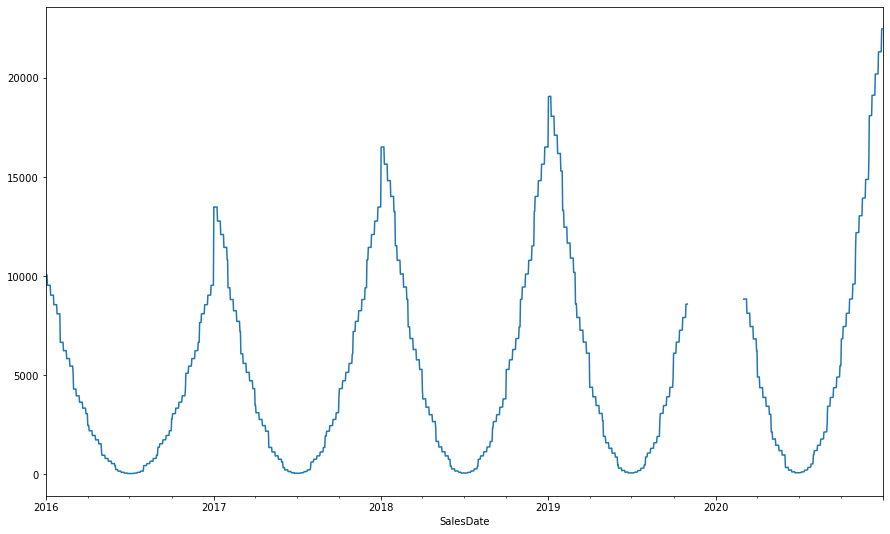

In [52]:
df_ts["SLSU"] = np.where(df_ts["moving_SLSU_median_3_lag_1y_DIFF_VS_SLSU"] >df_ts["IQR"],np.nan, df_ts["SLSU"])
df_ts["SLSU"].plot(figsize=(15,9));

następnie można uzupełnić dane dokonując predykcji np w oparciu od dane do połowy roku 2019, jakość predykcji ocenić można przez porównanie z niezaburzonymi obserwacjami, Do predykcji użyjemy tutaj modelu STLForecast, który dekomponuje szereg czasowy na trend, sezonowość i czynnik losowy i wykonuje predykcję odsezonowionych danych z użyciem modelu ARIMA

C:\Users\knajmajer\.conda\envs\politechnika\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\knajmajer\.conda\envs\politechnika\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\knajmajer\.conda\envs\politechnika\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\knajmajer\.conda\envs\politechnika\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


C:\Users\knajmajer\.conda\envs\politechnika\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='SalesDate'>

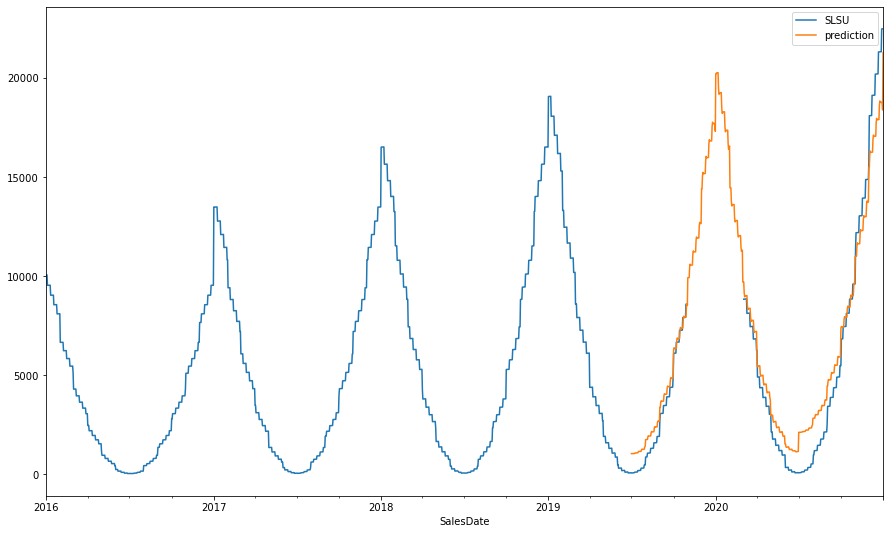

In [53]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
test_start = "2019-07-01"
df_ts_train = df_ts.loc[df_ts.index<test_start,"SLSU"]
df_ts_test = df_ts.loc[df_ts.index>=test_start, "SLSU"]
model = STLForecast(df_ts_train, ARIMA, model_kwargs={"order": (3,2,3)}, period=365)
stl = model.fit()
df_ts.loc[df_ts.index>=test_start, "prediction"] =stl.forecast(len(df_ts_test))
df_ts[["SLSU", "prediction"]].plot(figsize=(15,9))

tym sposobem otrzymujemy oczyszczony szereg czasowy

<AxesSubplot:xlabel='SalesDate'>

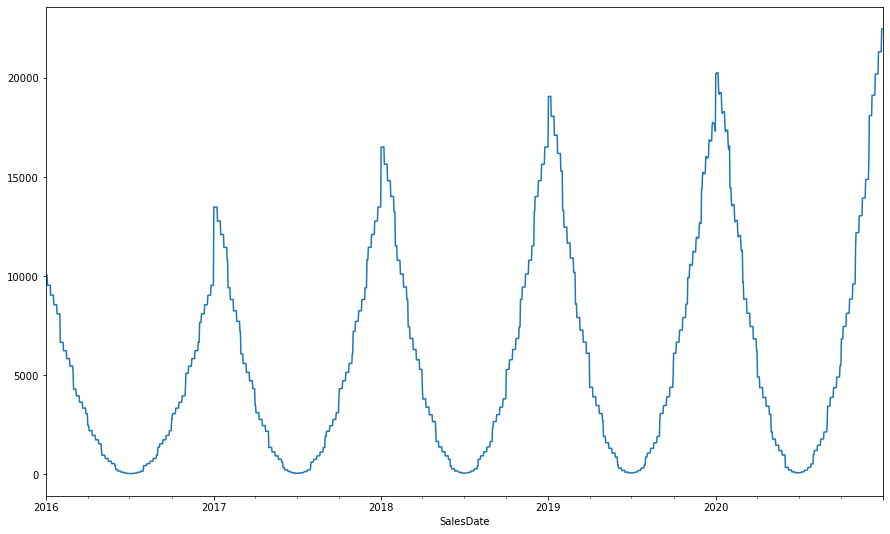

In [54]:
df_ts["SLSU"] = df_ts["SLSU"].fillna(df_ts["prediction"])
df_ts["SLSU"].plot(figsize=(15,9))